In [1]:
import numpy as np
from scipy import special
from matplotlib import pyplot as plt

from cosmoprimo.fiducial import DESI
from pypower import CatalogFFTPower

from mockfactory import EulerianLinearMock, RandomBoxCatalog, setup_logging

In [2]:
def kaiser_power(k, pklin, bias=1., f=0., qpar=1., qper=1.):
    pk = bias**2 * pklin.pk
    beta = f / bias
    pkell = []
    pkell.append((1. + 2. / 3. * beta + 1. / 5. * beta ** 2) * pk)
    pkell.append((4. / 3. * beta + 4. / 7. * beta ** 2) * pk)
    pkell.append(8. / 35 * beta ** 2 * pk)
    pkell = np.array(pkell)
    ells = (0, 2, 4)

    def pkmu(k, mu):
        return sum(np.interp(k, pklin.k, pkell[ill]) * special.legendre(ell)(mu) for ill, ell in enumerate(ells))

    def ap_k_mu(k, mu):
        jac = 1. / (qpar * qper**2)
        qap = qpar / qper
        factorap = np.sqrt(1 + mu**2 * (1. / qap**2 - 1))
        # Beutler 2016 (arXiv: 1607.03150v1) eq 44
        kap = k[..., None] / qper * factorap
        # Beutler 2016 (arXiv: 1607.03150v1) eq 45
        muap = mu / qap / factorap
        return jac, kap, muap

    mu = np.linspace(-1., 1., 500)
    jac, kap, muap = ap_k_mu(k, mu)
    pkell = [(2 * ell + 1) / 2. * jac * np.trapz(pkmu(kap, muap) * special.legendre(ell)(muap), x=muap) for ell in ells]
    return pkell

In [5]:
qpar=1.05
qper=0.95

nmesh = 300
boxsize = 1000
boxcenter = 0
seed = 42
f = 0.8
bias = 2.
los = 'x'
pklin = DESI().get_fourier().pk_interpolator().to_1d(z=1)
truncate = False

if truncate:
    k = pklin.k
    pk = pklin(k)
    sigma = 0.05
    kcut = 0.2
    mask = k > kcut
    pk[mask] = pk[mask] * np.exp(-(k[mask] - kcut)**2 / (2 * sigma ** 2))
    #from scipy.interpolate import InterpolatedUnivariateSpline
    #pklin = InterpolatedUnivariateSpline(k, pk, k=1)
    from cosmoprimo import PowerSpectrumInterpolator1D
    mask = k < 1.
    pklin = PowerSpectrumInterpolator1D(k=k[mask], pk=pk[mask])

In [6]:
# unitary_amplitude forces amplitude to 1
mock = EulerianLinearMock(pklin, nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, seed=seed, unitary_amplitude=True)
mock.set_real_delta_field(bias=bias)
mock.set_rsd(f=f, los=los)

In [7]:
data = RandomBoxCatalog(nbar=8e-3, boxsize=boxsize, boxcenter=boxcenter, seed=seed)
data['Weight'] = mock.readout(data['Position'], field='delta', resampler='tsc', compensate=True) + 1.
qs = np.array([qper, qper, qper])
qs['xyz'.index(los)] = qpar
data['Position'] /= qs
boxsize /= qs
#nmesh = ((nmesh / qs).astype(int) // 2) * 2

In [8]:
poles = CatalogFFTPower(data_positions1=data['Position'], data_weights1=data['Weight'], edges={'step': 0.01},
                        los=los, boxsize=boxsize, boxcenter=boxcenter, nmesh=nmesh,
                        resampler='tsc', interlacing=3,
                        position_type='pos', mpicomm=data.mpicomm).poles

In [9]:
ells = (0, 2, 4)
kth = poles.k[poles.k > 0]
theory = kaiser_power(kth, pklin, bias=bias, f=f, qpar=qpar, qper=qper)
theory_fid = kaiser_power(kth, pklin, bias=bias, f=f, qpar=1., qper=1.)

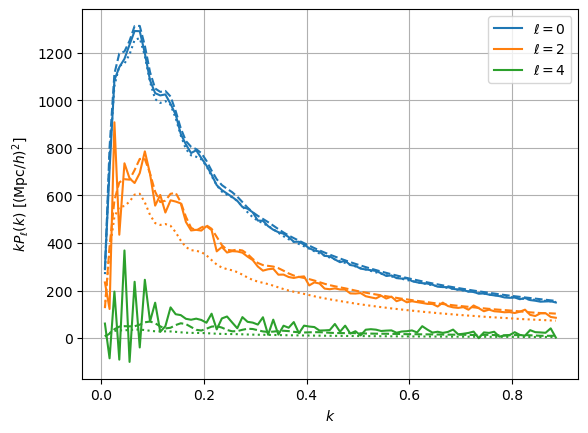

In [10]:
ax = plt.gca()
for ill, ell in enumerate(ells):
    ax.plot(poles.k, poles.k * poles(ell=ell, complex=False), color='C{:d}'.format(ill), label=r'$\ell = {:d}$'.format(ell))
    ax.plot(kth, kth * theory_fid[ill], linestyle=':', color='C{:d}'.format(ill))
    ax.plot(kth, kth * theory[ill], linestyle='--', color='C{:d}'.format(ill))
ax.legend()
ax.grid(True)
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
if data.mpicomm.rank == 0:
    plt.show()